# **Natural Language Understanding Final Project**
### Maria Vittoria Cavicchioli (230483) - 29 July 2022

**Description**: implementation of a Language Model using one of the RNN architectures (eg. Vanilla, LSTM, GRU)

**Dataset**: Penn Treebank

**Main reference papers**: 

- Zaremba, Wojciech, et al. _Recurrent Neural Network Regularization._ 1 Sept. 2014. NASA ADS, https://ui.adsabs.harvard.edu/abs/2014arXiv1409.2329Z.

- Gal, Yarin, and Zoubin Ghahramani. _A Theoretically Grounded Application of Dropout in Recurrent Neural Networks._ arXiv:1512.05287, arXiv, 5 Oct. 2016. arXiv.org, http://arxiv.org/abs/1512.05287.

**Acknowledgement**: since this is one of the first times I try to implement deep neural architectures I needed some help to get started. That's why I used some GitHub repositories to first understand the usage of the main functions. For some small parts of the code I also took inspiration from them but the majority of the code was developed by me. 

Here are the repositories that I investigated the most to understand things:
- [`floydhub/word-language-model`](https://github.com/floydhub/word-language-model/tree/19eac43f43bdb415aa8b23d9827ccd410f15e545)
- [`ahmetumutdurmus/zaremba`](https://github.com/ahmetumutdurmus/zaremba)
- [`wojzaremba/lstm`](https://github.com/ahmetumutdurmus/zaremba)
- [`PetrochukM/PyTorch-NLP`](https://github.com/PetrochukM/PyTorch-NLP)




I will use [PyTorch-NLP](https://pytorchnlp.readthedocs.io/en/latest/index.html) to retrieve and easily manipulate the Penn Treebank dataset. However, due to some lack of compatibility between the latest version of PyTorch (1.12.0+cu113) and PyTorch-NLP `BPTTBatchSampler`, I installed an older version of PyTorch (1.8.0+cu111).

Sometimes at the end of the installation it is asked to restart runtime. After the restarting, the correct version of PyTorch will be there.

In [ ]:
# Install Pytorch-NLP and the PyTorch version compatible with 'BPTTBatchSampler'
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-nlp

In [2]:
print("Importing required libraries...")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

try:
    from torchnlp.datasets import penn_treebank_dataset  
    from torchnlp.samplers import BPTTBatchSampler
    from torchnlp.encoders import LabelEncoder
    from torchnlp.nn import LockedDropout
except:
    if torch.__version__ != "1.8.0+cu111":
        print("You don't have the correct version of PyTorch! Please install version 1.8.0+cu111 using commad above.")

import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


print("All packages correctly loaded!")

print("PyTorch version ", torch.__version__)

Importing required libraries...
All packages correctly loaded!
PyTorch version  1.8.0+cu111


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# change the directory to the folder where the notebook is placed
%cd /content/drive/MyDrive/Colab Notebooks/NLUproj2022
! ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/10ntVgv5dvIM_diD5JVIcADDP01ojdp1j/NLUproj2022
data  NLUnotebook.ipynb  trained_models


## **Dataset Analysis**
I now load and analyze the Penn Treebank dataset [[1](https://aclanthology.org/J93-2004/)]

In [47]:
# (PyTorch-NLP) 'penn_treebank_dataset' loads the Penn Treebank Project: 
# Release 2 CDROM, featuring a million words of 1989 Wall Street Journal material.

train, val, test = penn_treebank_dataset(train=True, dev = True, test = True)

corpus = train + val + test
# (PyTorch-NLP) 'LabelEncoder' encodes labels via dictionary. It will contain the 
# vocabulary and useful methods to convert text into labels and vice versa

encoder = LabelEncoder(train, reserved_labels=[])


print("\nThe vocabulary size of the PTB corpus is ", encoder.vocab_size)
print("Train set size is {:d} | Validation set size is {:d} | Testing set size is {:d}".format(
    len(train), len(val), len(test)
    ))


The vocabulary size of the PTB corpus is  10000
Train set size is 929589 | Validation set size is 73760 | Testing set size is 82430


In [48]:
sents_len = np.empty([0])
counter = 0

for i in corpus:
    if i != "</s>":
        counter += 1
    else:
        counter += 1
        sents_len = np.append(sents_len, counter)
        counter = 0

avg_sent_len = np.mean(sents_len)
print("The average words per sentence are: {:.3f}".format(avg_sent_len))

The average words per sentence are: 22.069


A random example taken from the training PTB set shows us that sentences are already heavily pre-processed.

In [49]:
" ".join(train[41:53])

'mr. <unk> is chairman of <unk> n.v. the dutch publishing group </s>'

We also verify if Zipf's Law holds:

$k \approx r \cdot n$

Where $k$ is a constant, $n$ is the word frequency inside the corpus and $r$ is the word rank.

In [50]:
# we first remove the symbols used for processing the corpus 
train_clean = [word for word in train if word != "</s>" and word != "<unk>" and word != "N" and word != "$"]
val_clean = [word for word in val if word != "</s>" and word != "<unk>" and word != "N" and word != "$"]
test_clean = [word for word in test if word != "</s>" and word != "<unk>" and word != "N" and word != "$"]

corpus_clean = train_clean + val_clean + test_clean

In [51]:
freq_list = Counter(corpus_clean)

x = []
y = []
k_all = np.empty(len(freq_list))

display = 10
print("|Rank|Freq|Word|")
print("================")
for i, word in enumerate(freq_list.most_common(len(freq_list))):
    x.append(i+1)
    y.append(word[1]/len(corpus))
    k_all[i] = (i+1)*(word[1]/len(corpus))
    if display > 0:
        print("|{:d}|{:d}|{}|".format(i+1, word[1], word[0]))
        display -= 1

|Rank|Freq|Word|
|1|59421|the|
|2|28427|of|
|3|27430|to|
|4|24755|a|
|5|21032|in|
|6|20404|and|
|7|11555|'s|
|8|10436|for|
|9|10419|that|
|10|8533|is|


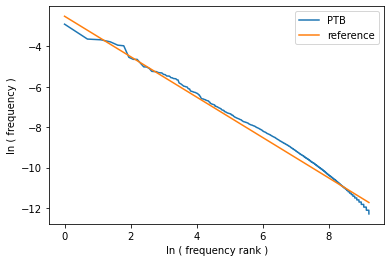

In [53]:
k = np.mean(k_all)

# we create a reference
r = np.linspace(1,len(x),len(x)*10)
n = k/r

plt.plot(np.log(x),np.log(y), label = "PTB")
plt.plot(np.log(r),np.log(n), label = "reference")
plt.xlabel('ln ( frequency rank )')
plt.ylabel('ln ( frequency )')
plt.legend()

plt.show()

## **Model Architecture**

We now define the RNN model architecture with LSTM units used in this project that follows *Zaremba et al.* [[2](https://arxiv.org/abs/1409.2329)]

Architecture overview:


```
Architecture(
  (emb): Embedding(vocab_size, custom_emb_dim)
  (rnn): LSTM(custom_emb_dim, custom_hidden_size, num_layers= custom_nLayers)
  (decoder): Linear(in_features=custom_hidden_size, out_features=vocab_size, bias=True)
)
```

This is the base for all the NNs used in this project. Depending on the version we are dealing with dropout will be used in different ways and places. 





In this first model implementation the dropout variable is unique and it will just store a probability of units drop. However, in this case the dropout will be applied on non-recurrent connections of the LSTM (as well as on generated embeddings and final output) in a naive manner.

<img src="https://i.ibb.co/h8yrcHV/dropouts-Copy.png" alt="dropouts-Copy" border="0" width = 400>

_Image taken from Gal et al. paper_ [[3](http://arxiv.org/abs/1512.05287)]



In [54]:
class Model(nn.Module):

    def __init__(self, vocab_size, emb_dim, nhid, nlayers, winit, dropout=0.5): 
        super(Model, self).__init__()
        
        self.drop = nn.Dropout(dropout)
        self.emb = nn.Embedding(vocab_size, emb_dim) 
        self.rnn = nn.LSTM(emb_dim, nhid, nlayers, dropout=dropout) 
        self.decoder = nn.Linear(nhid, vocab_size)
        
        self.winit = winit
        self.nhid = nhid
        self.nlayers = nlayers
        
        self.init_weights()
        
    def init_weights(self):
        # Paper 4.1 ~ units of the layers are initialized uniformly in [-winit, winit] 
        self.emb.weight.data.uniform_(-self.winit , self.winit )
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-self.winit , self.winit )

    def init_hidden(self, batch_size):
        # Paper 4.1 ~ initialize the hidden states to zero 
        weight = next(self.parameters()).data
        return weight.new_zeros(self.nlayers, batch_size, self.nhid), weight.new_zeros(self.nlayers, batch_size, self.nhid)

    def forward(self, input, hidden):
        emb = self.drop(self.emb(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded, hidden

This is the second model implementation where I follow the idea of _Gal et al._ [[3](http://arxiv.org/abs/1512.05287)]

<img src="https://i.ibb.co/4N1rTQn/dropouts-Copy-Copy.png" alt="dropouts-Copy-Copy" border="0" width = 400>

_Image taken from Gal et al. paper_ [[3](http://arxiv.org/abs/1512.05287)]

In this case I tried to replicate exactly what we see in the picture. 

```
self.dropout_embedding = LockedDropout(dropout_embedding) # blue
self.dropout_rnnhid1 = LockedDropout(dropout_rnnhid) # orange
self.dropout_rnnhid2 = LockedDropout(dropout_rnnhid) # dark red
self.dropout_rnnlay = LockedDropout(dropout_rnnlay) # green
self.dropout_finalout = LockedDropout(dropout_finalout) # bright red
```



In [55]:
class VarModel(nn.Module):

    def __init__(self, vocab_size, emb_dim, nhid, nlayers, winit,
                 dropout_embedding=0.5,
                 dropout_rnnhid=0.5,
                 dropout_rnnlay=0.5,
                 dropout_finalout=0.5
                 ): 


        super(VarModel, self).__init__()

        # (PyTorch-NLP) 'LockedDropout' allows to create a dropout mask
        self.dropout_embedding = LockedDropout(dropout_embedding)
        self.dropout_rnnhid1 = LockedDropout(dropout_rnnhid)
        self.dropout_rnnhid2 = LockedDropout(dropout_rnnhid)
        self.dropout_rnnlay = LockedDropout(dropout_rnnlay)
        self.dropout_finalout = LockedDropout(dropout_finalout)


        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn1 = nn.LSTM(emb_dim, nhid, 1, dropout=0) 
        self.rnn2 = nn.LSTM(emb_dim, nhid, 1, dropout=0) 
        self.decoder = nn.Linear(nhid, vocab_size)
        
        self.decoder.weight = self.emb.weight
        
        self.winit = winit
        self.nhid = nhid
        self.nlayers = nlayers
        
        self.init_weights()
        
    def init_weights(self):
        self.emb.weight.data.uniform_(-self.winit , self.winit )
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-self.winit , self.winit )

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return [(weight.new_zeros(1, batch_size, self.nhid, device = "cuda:0"),
                weight.new_zeros(1, batch_size, self.nhid, device = "cuda:0"))
                for l in range(self.nlayers)]

    def forward(self, input, hidden):
        emb = self.dropout_embedding(self.emb(input))
        new_hidden = []
        out1, h1 = self.rnn1(emb, (self.dropout_rnnhid1(hidden[0][0]), self.dropout_rnnhid1(hidden[0][1])))
        out1 = self.dropout_rnnlay(out1)
        out2, h2 = self.rnn2(out1, (self.dropout_rnnhid1(hidden[1][0]), self.dropout_rnnhid1(hidden[1][1])))
        hidden = [h1,h2]
        output = self.dropout_finalout(out2)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded, hidden

In [12]:
def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

## **Train and Test steps**

In [13]:
def test_step(data_tensor, source_slices, target_slices):
    model.eval()
    total_loss = 0
    tot_samples = 0

    with torch.no_grad():
        hidden = model.init_hidden(batch_size)
        
        for source_slice, target_slice in zip(source_slices, target_slices):
            data = torch.stack([data_tensor[i] for i in source_slice], dim = 1)
            targets = torch.stack([data_tensor[i] for i in target_slice], dim = 1).view(-1)
            
            output, hidden = model(data, hidden)

            loss = criterion(output, targets) * output.size(0)
            total_loss += loss
            tot_samples += output.size(0)

        avg_loss = total_loss/tot_samples
        avg_ppl = math.exp(avg_loss)
    return avg_loss, avg_ppl

In [14]:
def train_step():
    model.train()
    hidden = model.init_hidden(batch_size)
    
    batch = 0
    if epoch >= epoch_decay_lr:
        scheduler.step() 

    
    for source_slice, target_slice in zip(train_source_sampler, train_target_sampler):
            

        data = torch.stack([train_data[i] for i in source_slice], dim =1)
        targets = torch.stack([train_data[i] for i in target_slice], dim = 1).view(-1)

        hidden = repackage_hidden(hidden)   

        optimizer.zero_grad()

        output, hidden = model(data, hidden)

        loss = criterion(output, targets)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        
        if batch%report_iterations == 0:
            print('| epoch {:d} | {:d}/{:d} batches | lr {:.3f} | loss {:.3f} |'.format(
                epoch+1, batch, len(train_source_sampler), scheduler.get_last_lr()[0], loss.item()
            ), file = f)

        
        batch += 1


In [15]:
# Use the CUDA variable below to decide if training on GPU or CPU
# Note that all my experiments ran on GPU

cuda = True

if torch.cuda.is_available() and cuda:
    print("Model will be training on the GPU.\n")
    pass
    
else:
    cuda = False
    print("Model will be training on the CPU.\n")

torch.cuda.manual_seed(5) if cuda else torch.manual_seed(5)

Model will be training on the GPU.



In [56]:
# decide batch size and sequence length to feed to the model

seq_len = 35 
batch_size = 20 

if cuda:
    print("Loading data on GPU...")
    train_data = encoder.batch_encode(train).cuda()
    val_data = encoder.batch_encode(val).cuda()
    test_data = encoder.batch_encode(test).cuda()
else:
    print("Loading data on CPU...")
    train_data = encoder.batch_encode(train)
    val_data = encoder.batch_encode(val)
    test_data = encoder.batch_encode(test)

# (PyTorch-NLP) 'BPTTBatchSampler' samples sequentially a batch of source and target slices of size bptt_length.
# Typically, such a sampler, is used for language modeling training with backpropagation through time (BPTT).

train_source_sampler, val_source_sampler, test_source_sampler = tuple(
    [BPTTBatchSampler(data = d, bptt_length = seq_len, batch_size = batch_size, 
                      drop_last = True, type_ = 'source') for d in (train, val, test)])

train_target_sampler, val_target_sampler, test_target_sampler = tuple(
    [BPTTBatchSampler(data = d, bptt_length = seq_len, batch_size = batch_size, 
                      drop_last = True, type_ = 'target') for d in (train, val, test)])

Loading data on GPU...


Here decide if:
- you what to train the model(s) from scratch or just load them
- If training from scratch is chosen:
  - how many times to train the chosen model
  - which type of model to train

In [46]:
# train = True --> train from scratch the model
# train = False --> load the model 

train = False
nruns = 1
ppls = np.zeros(nruns)

# model_type:
# 0 --> non-regularized LSTM
# 1 --> medium regularized LSTM
# 2 --> large regularized LSTM
# 3 --> variational LSTM

model_type = 3

ntokens = encoder.vocab_size

if model_type == 0:
  beg = "noREG"

  best_of_bests = 0
  
  emsize = 200 
  nhid = 200 
  nlayers = 2 
  dropout = 0.0 
  winit = 0.1 
  max_norm = 5
  factor = 0.5
  init_lr = 1 
  tot_epochs = 13 
  epoch_decay_lr = 4 
  report_iterations = 500 

elif model_type == 1:
  beg = "medREG"

  best_of_bests = 2

  emsize = 650 
  nhid = 650 
  nlayers = 2
  dropout = 0.5 
  winit = 0.05 
  max_norm = 5 
  factor = 0.83333
  init_lr = 1 
  tot_epochs = 39 
  epoch_decay_lr = 6 
  report_iterations = 500 

elif model_type == 2:
  beg = "largeREG"

  best_of_bests = 0
  
  emsize = 1500 
  nhid = 1500 
  nlayers = 2 
  dropout = 0.65 
  winit = 0.04 
  max_norm = 10
  factor = 0.8695652
  init_lr = 1 
  tot_epochs = 55 
  epoch_decay_lr = 14
  report_iterations = 500

else:
  beg = "varREG"

  best_of_bests = 3

  emsize = 650 
  nhid = 650 
  nlayers = 2
  dropout = 0.5
  winit = 0.05 
  max_norm = 5 
  factor = 0.83333
  init_lr = 1 
  tot_epochs = 39 
  epoch_decay_lr = 6
  report_iterations = 500

  dropout_embedding=0.5 
  dropout_rnnhid=0.3 
  dropout_rnnlay=0.4 
  dropout_finalout=0.5

# initialize the model
if model_type != 3:
  model = Model(ntokens, emsize, nhid, nlayers, winit, dropout)
else:
  model = VarModel(ntokens, emsize, nhid, nlayers, winit, dropout_embedding, dropout_rnnhid, dropout_rnnlay, dropout_finalout)

if cuda:
  model.cuda()


# initialize the optimizer, scheduler and criterion for the loss
optimizer = torch.optim.SGD(model.parameters(), lr= 1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = factor) 
criterion = nn.CrossEntropyLoss()

In [ ]:
if train:
  with open(beg+'out.txt', 'w') as f: 

      print("PARAMETERS", file = f)

      print("\nntokens = {:d}\nemsize = {:d}\nnhid = {:d}\nnlayers = {:d}\ndropout = {:.3f}\nwinit = {:.3f}\nmax_norm = {:d}\nfactor = {:.3f}\ninit_lr = {:d}\ntot_epochs = {:d}\nepoch_decay_lr = {:d}\nreport_iterations = {:d}".format(ntokens, emsize, nhid, nlayers,
                                                  dropout, winit, max_norm, factor,
                                                  init_lr, tot_epochs, epoch_decay_lr,
                                                  report_iterations), file = f)      
      print(model, file = f)

      for run in range(nruns):

          print("\n\nRUN {:d}\n\n".format(run+1), file = f)                   
          best_val_loss = []
          stored_loss = math.inf

          path_save_model = "./trained_models/"+beg
          
          for epoch in range (0, tot_epochs):
              
              print("\n##################################################################################\n", file = f)
              print("EPOCH: ", epoch+1, file = f)
              print("\nTrain ------------\n", file = f)
              train_step()
              print("\n\nValidation -------\n", file = f)
              val_avg_loss, val_avg_ppl = test_step(val_data, val_source_sampler, val_target_sampler)
              print("\nAvg loss: {:.3f} | Avg ppl: {:.3f}\n".format(val_avg_loss, val_avg_ppl), file = f)
              if val_avg_loss < stored_loss:
                  # torch.save(model.state_dict(), path_save_model+str(run)+".pt")
                  torch.save(model.state_dict(), path_save_model+str(4)+".pt")
                  print('\nSaving model (new best validation)', file = f)
                  stored_loss = val_avg_loss


          print("\n\n\n\n\nLoading the best model...\n", file = f)
          # model.load_state_dict(torch.load(path_save_model+str(run)+".pt"))
          model.load_state_dict(torch.load(path_save_model+str(4)+".pt"))
          
        
          print("*"*89, file = f)
          print("*"*89, file = f)
          print("\nTESTING ----------", file = f)
          test_avg_loss, test_avg_ppl = test_step(test_data, test_source_sampler, test_target_sampler)
          print("Avg loss: {:.3f} | Avg ppl: {:.3f}\n".format(test_avg_loss, test_avg_ppl), file = f)
          print("*"*89, file = f)
          print("*"*89, file = f)

          ppls[run] = test_avg_ppl

      best_of_bests = ppls.argmin()
      print("\n\nFinal average ppl over {:d} runs is {:.3f} with a standard deviation of {:.3f}".format(nruns, np.mean(ppls), np.std(ppls)), file = f)

      print("\nBest final model was the one in run ", best_of_bests, file = f)

      f.close()

else:
  path_load_model = "./trained_models/"+beg+str(best_of_bests)+".pt"

  print("\nLoading the best model...\n")
  model.load_state_dict(torch.load(path_load_model))

  print("\nTESTING ----------")
  test_avg_loss, test_avg_ppl = test_step(test_data, test_source_sampler, test_target_sampler)
  print("Avg loss: {:.3f} | Avg ppl: {:.3f}\n".format(test_avg_loss, test_avg_ppl))

## **Predict**

In [19]:
# given a initial sentence and a number of words to generate this function will use
# the last loaded model to predict the words
def predict_word(start_text, nwords2gen):
    start_text_processed = []
    for word in start_text:
      if word in encoder.vocab:
        start_text_processed.append(word)
      else:
        start_text_processed.append("<unk>")    
    
    new_words = torch.cuda.LongTensor()
    model.eval()
    with torch.no_grad():
        source = encoder.batch_encode(start_text_processed).cuda()
        source = torch.reshape(source, (list(source.size())[0], 1))

        hidden = model.init_hidden(1)
        soft = nn.Softmax(dim = 1)
        for i in range(nwords2gen):
          data4model = source

          output, hidden = model(data4model, hidden)

          next_word_probs = soft(output)[-1]
          
          get_word_idx = torch.multinomial(next_word_probs, 1)
          if get_word_idx == encoder.encode("<unk>") or get_word_idx == encoder.encode("N") or get_word_idx == encoder.encode("$"):
            next_word_probs[get_word_idx] = 0.
            get_word_idx = torch.multinomial(next_word_probs, 1)

          new_words = torch.cat((new_words, get_word_idx))
          get_word_idx = get_word_idx[-1:,None]
      
          source = torch.cat((source, get_word_idx), dim = 0)

          to_print = []
          for w in start_text+encoder.batch_decode(new_words):
            if w == "</s>":
              to_print.append(".")
            else:
              to_print.append(w)
          print(" ".join(to_print))        

In [57]:
# given a initial sentence and a number of sentences to generate this function will use
# the last loaded model to predict them
def predict_sent(start_text, nsent2gen):
    current_sent = 1
    start_text_processed = []
    for word in start_text:
      if word.lower() in encoder.vocab:
        start_text_processed.append(word.lower())
      else:
        start_text_processed.append("<unk>")    
    
    new_words = torch.cuda.LongTensor()

    stop_anyway = 0
    flag = False
    model.eval()
    with torch.no_grad():

        source = encoder.batch_encode(start_text_processed).cuda()
        source = torch.reshape(source, (list(source.size())[0], 1))

        hidden = model.init_hidden(1)
        soft = nn.Softmax(dim = 1)

        while current_sent <= nsent2gen:
          if stop_anyway < 30:
            data4model = source
            output, hidden = model(data4model, hidden)

            next_word_probs = soft(output)[-1]
            
            get_word_idx = torch.multinomial(next_word_probs, 1)
            while get_word_idx == encoder.encode("<unk>") or get_word_idx == encoder.encode("N") or get_word_idx == encoder.encode("$"):
              next_word_probs[get_word_idx] = 0.
              get_word_idx = torch.multinomial(next_word_probs, 1)

            if get_word_idx == encoder.encode("</s>"):
              current_sent +=1
              stop_anyway = 0


            new_words = torch.cat((new_words, get_word_idx))
            get_word_idx = get_word_idx[-1:,None]
        
            source = torch.cat((source, get_word_idx), dim = 0)
            stop_anyway +=1
          else:
            # uncomment below if you want to see the generated sentences
            # print("early stop\n")
            flag = True
            break

        to_print = []
        for w in start_text+encoder.batch_decode(new_words):
          if w == "</s>":
            to_print.append(".\n")
              
          else:
            to_print.append(w)
        # uncomment below if you want to see the generated sentences
        # print(" ".join(to_print))

        return to_print, flag

In [ ]:
how_many_next_words = 10
plain_txt = "The meaning of life is"

split_text = plain_txt.split()
predict_word(split_text, how_many_next_words)

In [58]:
nsent2gen =  2
plain_txt = "The meaning of life is"

split_text = plain_txt.split()
res,_ = predict_sent(split_text, nsent2gen)

In [ ]:
lens = np.empty(0)
stops = np.empty(0)
for i in range(100):
  nsent2gen =  1
  plain_txt = "The meaning of life is"

  split_text = plain_txt.split()

  sents_list, flag = predict_sent(split_text, nsent2gen)
  
  if not flag:
    avg_len = len(sents_list)/nsent2gen
    lens = np.append(lens, avg_len)
  else:
    stops = np.append(stops, sents_list.count(".\n"))

print("Among 100 trials of generating {:d} sentences, {:d} succeeded to do it.".format(nsent2gen, len(lens)))
print("Considering the successful trials, the average number of words per sentence is {:.3f}".format(np.mean(lens)))